#### Metode i primjena vjestacke inteligencije
#### Laboratorijska vjezba 10
#### Student: Masovic Haris
#### Index: 1689/17993

## 0. Dependencies 



In [ ]:
import sys
from google.colab import drive 

drive.mount('/content/gdrive')
!{sys.executable} -m pip install matplotlib Image

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 4. Implementacija

### 4.1 Model generatora

In [ ]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape = (latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2D(256, 5, padding = 'same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 4, strides = 2, padding = 'same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding = 'same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding = 'same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(channels, 7, activation = 'tanh', padding = 'same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

### 4.2 Model diskriminatora

In [ ]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 6, 6, 128)         0   

### 4.3 Povezivanje u sistem i treniranje

In [ ]:
import os
from keras.preprocessing import image

discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.RMSprop(lr = 0.0004, clipvalue = 1.0, decay = 1e-8)
gan.compile(optimizer = gan_optimizer, loss = 'binary_crossentropy')

(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

x_train = x_train[y_train.flatten() == 6]
x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = '/content/gdrive/MyDrive/Colab Notebooks/saved_frogs'
start = 0

for step in range(iterations):
    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    start += batch_size
    
    if start > len(x_train) - batch_size:
        start = 0
    
    if step % 100 == 0:
        gan.save_weights('gan.h5')
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)
            
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,'generated_frog' + str(step) + '.png'))
            
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

discriminator loss: 6.304964065551758
adversarial loss: 8.318703651428223
discriminator loss: 0.10974375158548355
adversarial loss: 1.9302780628204346
discriminator loss: -2.056602716445923
adversarial loss: 150.48727416992188
discriminator loss: 0.7964155673980713
adversarial loss: 1.5259902477264404
discriminator loss: 0.302849143743515
adversarial loss: 5.863648414611816
discriminator loss: 0.7684347033500671
adversarial loss: 1.0409116744995117
discriminator loss: 0.7037466764450073
adversarial loss: 1.1192209720611572
discriminator loss: 0.6834160089492798
adversarial loss: 0.7261267304420471
discriminator loss: 0.716108500957489
adversarial loss: 0.7231886386871338
discriminator loss: 0.6888271570205688
adversarial loss: 0.7416106462478638
discriminator loss: 0.7219308614730835
adversarial loss: 0.7946231961250305
discriminator loss: 0.6959607005119324
adversarial loss: 0.7668138742446899
discriminator loss: 0.6786139607429504
adversarial loss: 0.7790461778640747
discriminator lo

## 5. Zadatak

#### 5.0.1 Detaljno proucite kod u for petlji u listingu broj 3 i prepoznajte dijelove koda koji se podudaraju sa koracima u pseudokodu (Algoritam 1), te iste ispisite u izvjestaju u formatu komanda iz pseudeokoda - linija koda

Dijelovi koda koji se podudaraju sa koracima su:
- Uzorkovanje od skupa m clanova suma - 29
- Uzorkovanje skupa od m uzoraka iz distribucije skupa podataka za trening - 34
- Azuriranje modela diskriminatora metodom uzlaznog stohasticnog gradijenta - 35
- Uzorkovanje od skupa m clanova suma - [37,39]
- Azuriranje modela generatora metodom silaznog stohasticnog gradijenta - 41

#### 5.0.2 Iskoristite prilozeni kod i istrenirajte sistem generativnih protivnickih mreza, a zatim iskoristite dobijeni model generatora za generisanje deset novih slika zaba. Prokomentarisite realisticnost generisanih uzoraka.

- Istreniran je sistem generativnih protivnickih mreza, te je isti model iskoristen za generisanje 10 novih slika zaba, te slike su prikazane ispod.
- Gledajuci dobijene uzorke, nije toliko realisticno da se usporedi sa pravom zabom, poredeci prave slike koje se koristi u train dataset-u.

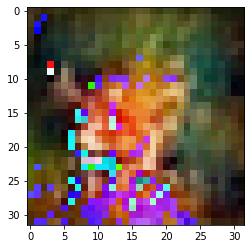

In [ ]:
import matplotlib.pyplot as plt

def generate_image():
    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))
    gen_images = generator.predict(random_latent_vectors)
    img = image.array_to_img(gen_images[0] * 255., scale=False)
    plt.imshow(img)
    plt.show()


generate_image()

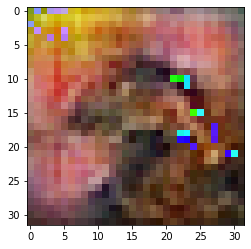

In [ ]:
generate_image()

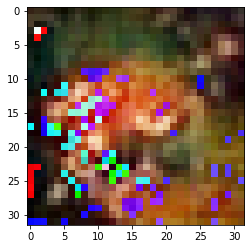

In [ ]:
generate_image()

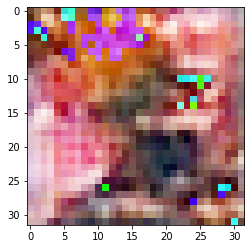

In [ ]:
generate_image()

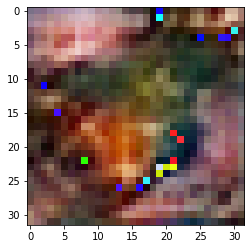

In [ ]:
generate_image()

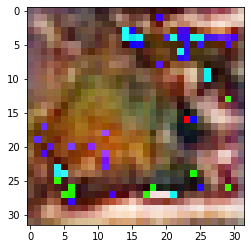

In [ ]:
generate_image()

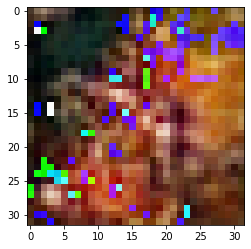

In [ ]:
generate_image()

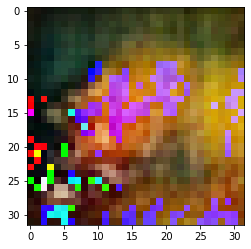

In [ ]:
generate_image()

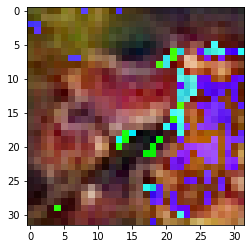

In [ ]:
generate_image()

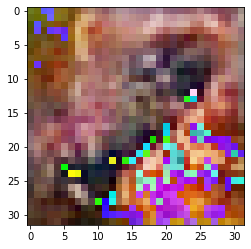

In [ ]:
generate_image()